In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import itertools
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


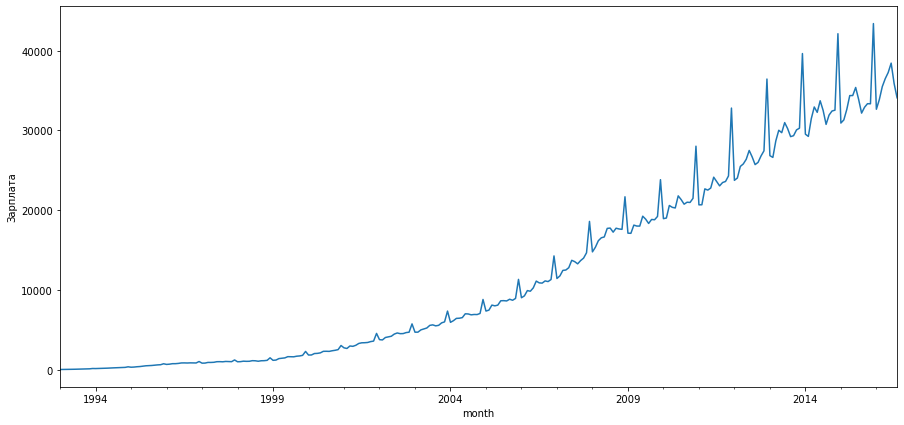

In [2]:
data = pd.read_csv('/home/alexander/Загрузки/zarplata.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.rename(columns={"WAG_C_M":"salary"}, inplace=True)
plt.figure(figsize(15,7))
data.salary.plot()
plt.ylabel('Зарплата')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

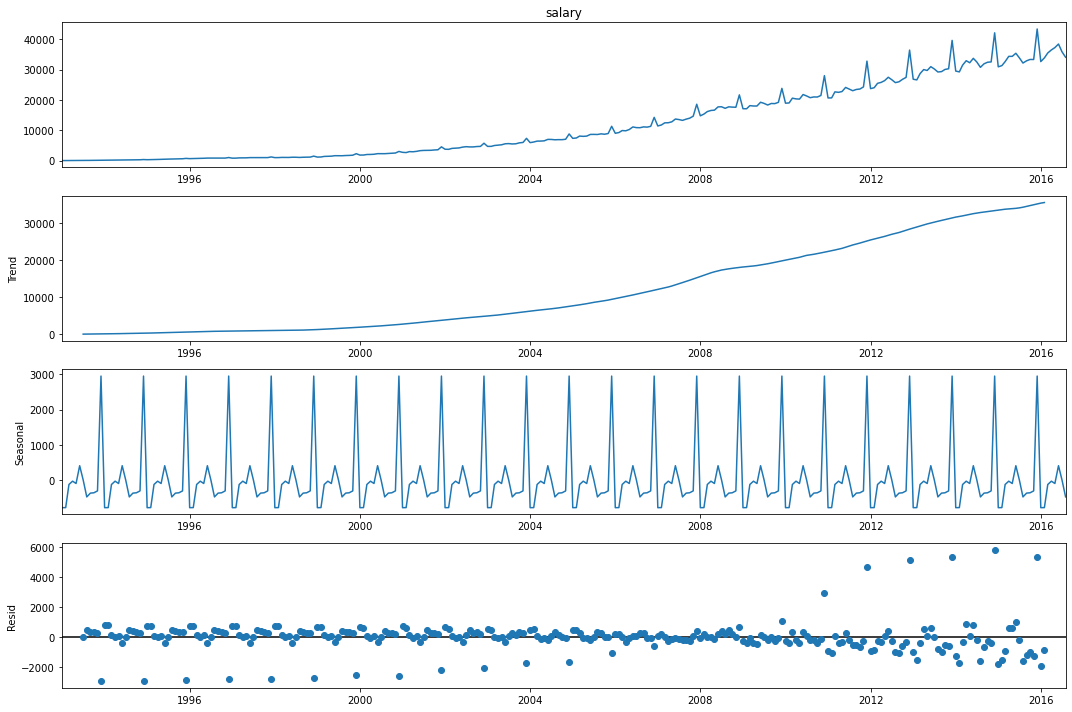

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


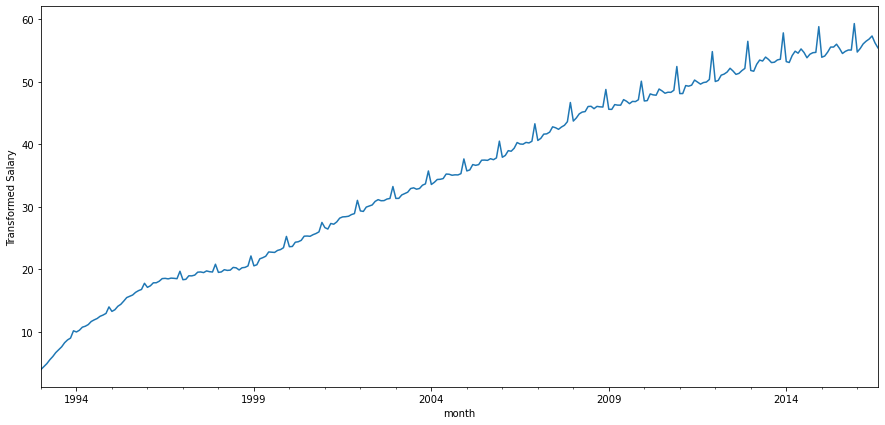

In [5]:
data['salary_box'], lmbda = stats.boxcox(data.salary)
plt.figure(figsize(15,7))
data.salary_box.plot()
plt.ylabel(u'Transformed Salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

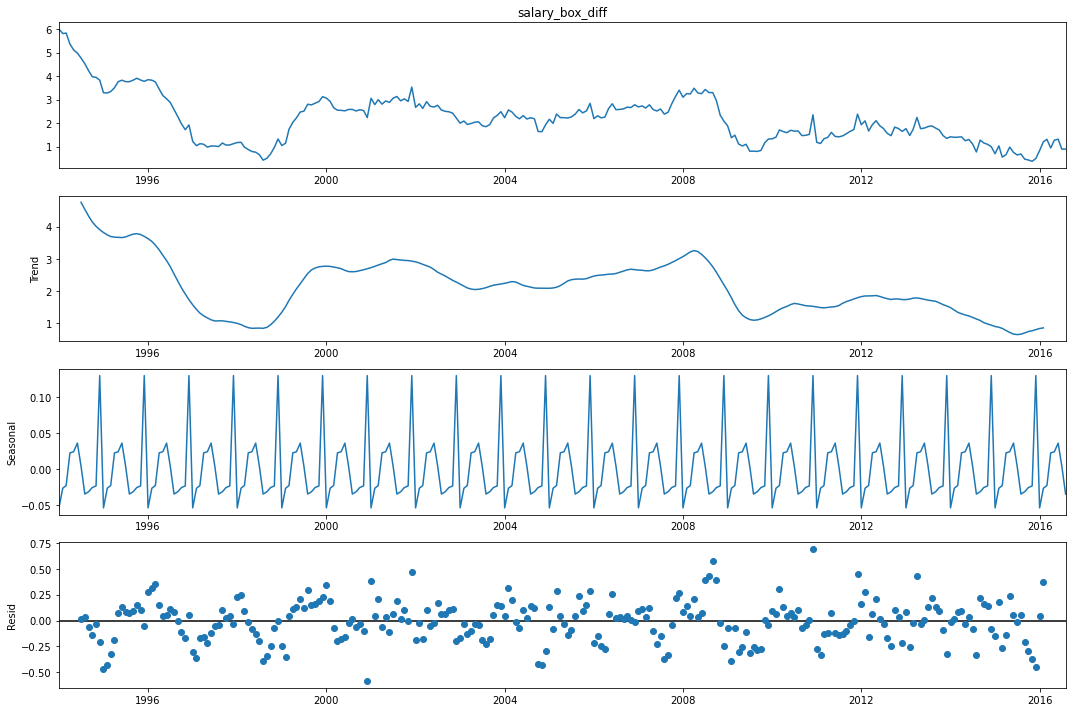

In [6]:
data['salary_box_diff'] = data.salary_box - data.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

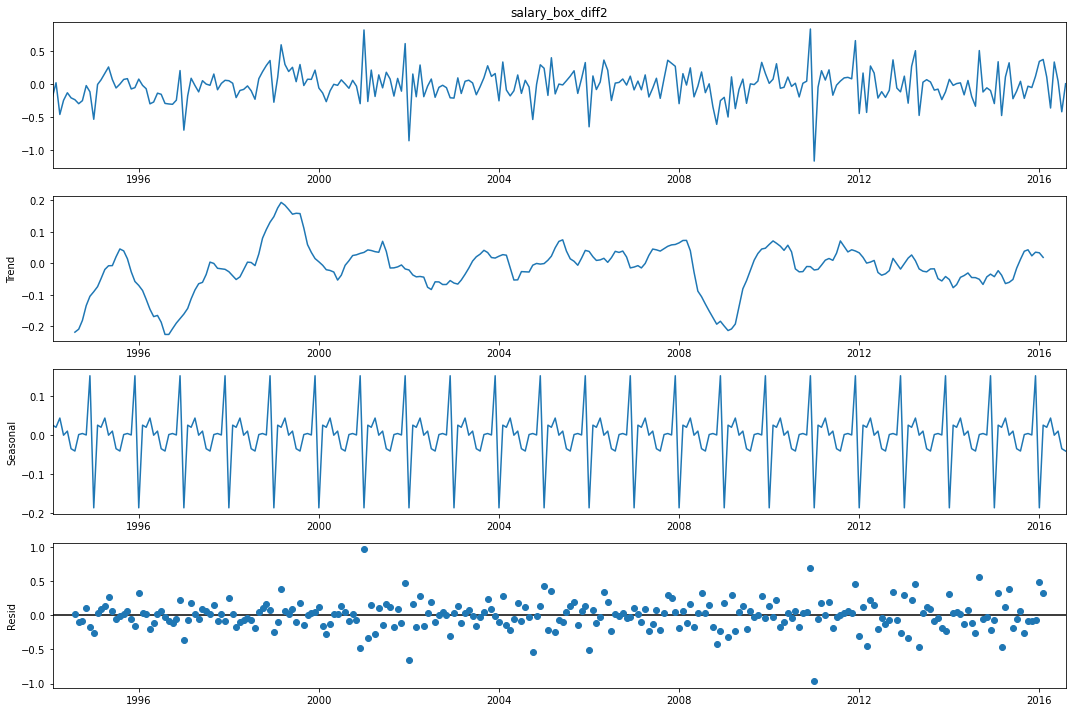

In [7]:
data['salary_box_diff2'] = data.salary_box_diff - data.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

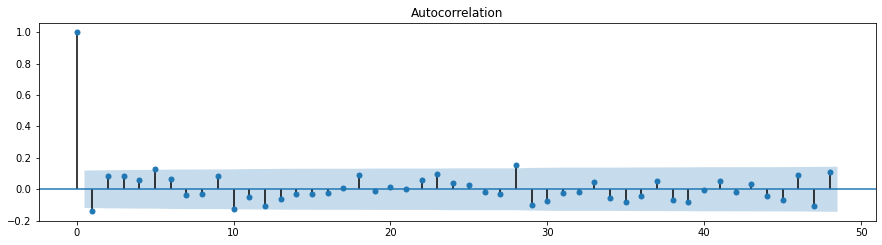

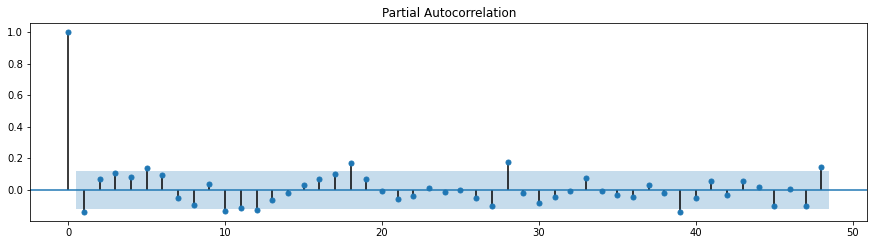

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выбор начальных приближений:

Период у сезона = 12 (годичная сезонность)

Q = 0, т.к значимых сезонных значений нет (значения кратные 12)

q = 1, т.к все значимые несезонные значения - 0, 1, 5, 10, 28. Но не стоит брать большие значения т.к. итоговая оптимизируемая функция - функция Акаике

P = 4, т.к. значимое сезонное значение  𝑃∗𝑆=48  значит  𝑃=4 

p = 10, т.к. все возможные значения - 0, 1, 10, 11, 18, 28, 39.

In [10]:
D=1
d=1
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 5)
ps = range(0, 11)

In [13]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

110

In [14]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 6min 10s, sys: 3.11 s, total: 6min 13s
Wall time: 3min 13s


In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters       aic
61    (6, 0, 1, 0) -7.552970
106  (10, 1, 1, 0) -7.168052
62    (6, 0, 2, 0) -6.480323
64    (6, 0, 4, 0) -6.327815
105  (10, 1, 0, 0) -5.958379


Лучшая модель:

In [16]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  11.776
Date:                            Sun, 11 Oct 2020   AIC                             -7.553
Time:                                    11:19:30   BIC                             21.264
Sample:                                01-01-1993   HQIC                             4.017
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1991      0.045     -4.402      0.000      -0.288      -0.110
ar.L2          0.0224      0.066   

Её остатки:

Критерий Стьюдента: p=0.293091
Критерий Дики-Фуллера: p=0.000000


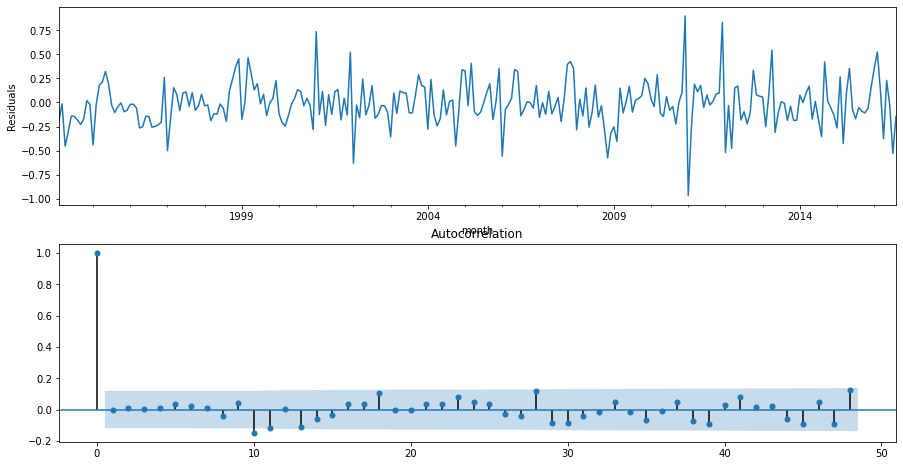

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

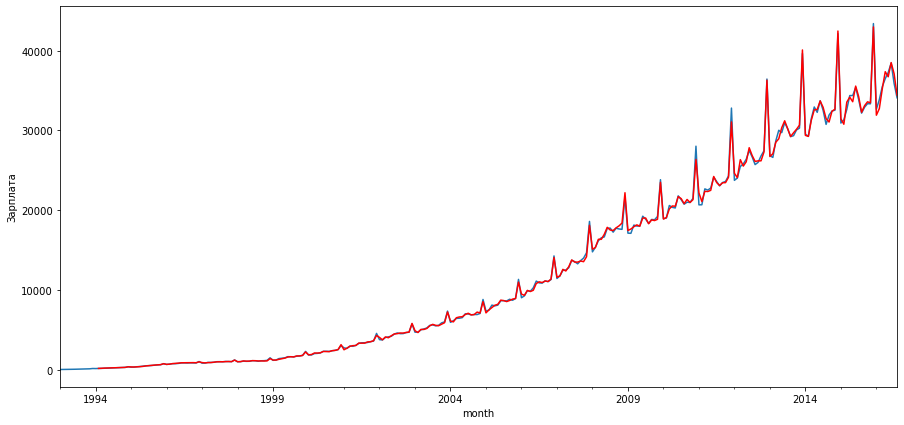

In [18]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.salary.plot()
data.model[13:].plot(color='r')
plt.ylabel('Зарплата')
pylab.show()

### Прогноз

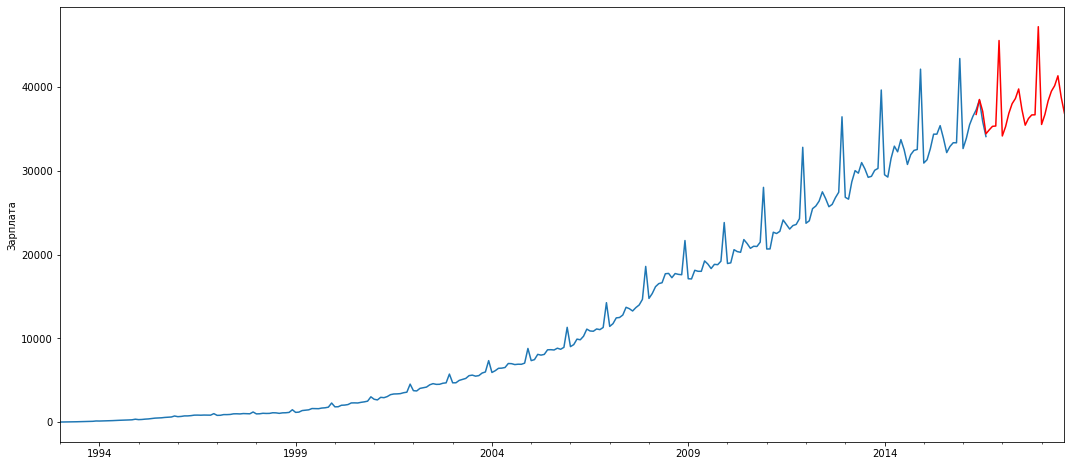

In [19]:
data2 = data[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=280, end=320), lmbda)

plt.figure(figsize(18,8))
data2.salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('Зарплата')
pylab.show()

In [20]:
data2.forecast[280:]

2016-05-01    36735.566672
2016-06-01    38516.687580
2016-07-01    37110.777878
2016-08-01    34418.234772
2016-09-01    34889.717869
2016-10-01    35314.337669
2016-11-01    35350.518437
2016-12-01    45556.804806
2017-01-01    34161.475532
2017-02-01    35275.269499
2017-03-01    36868.159397
2017-04-01    38014.683633
2017-05-01    38630.797987
2017-06-01    39773.260577
2017-07-01    37308.164312
2017-08-01    35450.064579
2017-09-01    36244.409330
2017-10-01    36674.163327
2017-11-01    36688.888647
2017-12-01    47207.467391
2018-01-01    35536.084297
2018-02-01    36700.846403
2018-03-01    38349.089247
2018-04-01    39501.379225
2018-05-01    40163.159903
2018-06-01    41347.029996
2018-07-01    38777.723223
2018-08-01    36865.132693
Name: forecast, dtype: float64